In [1]:
# Load libraries
import re
import sys
import math
import string
import zipfile
import unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from gensim.models import KeyedVectors

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential, Model
from keras import initializers, regularizers, constraints
from keras.layers import LSTM, Dense, Bidirectional, Input, Dropout

# **I. Chuẩn bị dữ liệu**

# 1. Load bộ dữ liệu

**Problem**

Phải load bộ dữ liệu lên mẫu để xử lý

**Solution**

Sử dụng hàm ```read_csv``` của thư viện pandas để load file CSV 

In [2]:
# Load datasets
train_df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test_dataframe = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')

# 2. Miêu tả bộ dữ liệu

**Problem**

Hiển thị một số đặc điểm cơ bản của của bộ dữ liệu

**Solution**

Sau khi hoàn thành việc load dữ liệu.
* Đơn giản nhất là hiển thị vài dòng của dữ liệu, sử dụng ```head``` để xem những dòng đầu tiên hoặc ```tail``` để quan sát những dòng cuối cùng
* Có thể lấy được số dòng và số cột của bộ dữ liệu, sử dụng ```shape```
* Bên cạch đó, ta có thể miêu tả một vài thống kê cơ bản hoặc sử dụng thư viện **matplotlib** để visualize các thông số của dữ liệu.

**Discussion**

Sau khi load xong bộ, dữ liệu, phải hiểu được cấu trúc của nó cũng như các trường thông tin mà dữ liệu sở hữu. Trong bài toán phân loại mà chúng ta đang giải quyết, ta có thể thấy:
* Dữ liệu gồm 3 trường, trong đó ta chỉ cần quan tâm đến cột **question_text** là nội dung của câu hỏi mình cần phân loại, cũng như **target** là dữ liệu kiểu BINARY với giá trị 1 là câu hỏi toxic, ngược lại 0 là câu hỏi non-toxic
* Dữ liệu test gồm 1306122 câu hỏi
* Sử dụng phương pháp được nêu trên, nhận thấy các câu hỏi trong bộ dữ liệu có chứa trung bình 12.8 từ trong một câu và trong một câu có trung bình 70.68 ký tự

In [3]:
# View first five rows
train_df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
# Show dimensions
train_df.shape

(1306122, 3)

In [5]:
# Show statistics
total_word_length = 0
for text in train_df['question_text']:
    total_word_length += len(text.split())
print('Average of Words in Questions: {:.2f} (words)'.format(total_word_length / len(train_df)))

total_char_length = 0
for text in train_df['question_text']:
    total_char_length += len(text)
print('Average length of Questions: {:.2f} (characters)'.format(total_char_length / len(train_df)))

Average of Words in Questions: 12.80 (words)
Average length of Questions: 70.68 (characters)


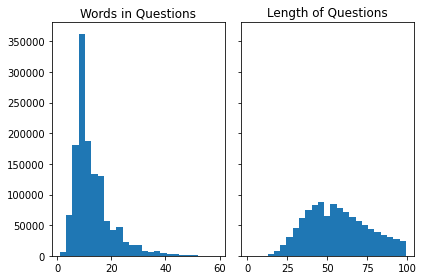

In [6]:
# Plot histogram of text lengths
word_length_list = [len(x.split()) for x in train_df['question_text'] if len(x.split()) < 60]
char_length_list = [len(x) for x in train_df['question_text'] if len(x) < 100]
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(word_length_list, bins=25)
axs[0].set_title('Words in Questions')

axs[1].hist(char_length_list, bins=25)
axs[1].set_title('Length of Questions')
plt.show()

# 3. Chuẩn bị dữ liệu train và dữ liệu validate

**Problem**

Với các bài toán học máy, ta phải train mô hình của mình, cũng như validate lại độ chính xác của nó.

**Solution**

Ta được cung cấp 1 file csv về bộ dữ liệu train, đây là bộ dữ liệu đã có target của từng câu hỏi. Vì vậy, ta sẽ tách bộ dữ liệu đó thành 2 phần, một phần để train, phần còn lại để test, kiểm tra độ đúng đắn của mô hình.

Sử dụng hàm ```train_test_split``` của thư viện **sklearn** để chia bộ dữ liệu.

**Discussion**

Rõ ràng, ta phải dùng phần lớn dữ liệu cho việc train, tuy nhiên để đảm bảo độ chính xác, cũng không được dùng quá ít dữ liệu cho việc validate. Bộ dữ liệu của bài toán cũng đã khá lớn, nên việc chia tỉ lệ này cũng sẽ không quá ảnh hưởng, ta sẽ chia theo tỉ lệ 9:1.

In [7]:
# Create training and validation sets
train_dataframe, val_dataframe = train_test_split(train_df, test_size=0.1)

# **II. Xử lý dữ liệu**

# 1. Load bộ Embeddings

**Problem**

Dữ liệu dạng text không thể dùng để train mô hình học máy được.

**Solution**

Word Embedding là quá trình đưa các từ trong câu về dạng để mô hình có thể hiểu được. Cụ thể trong bài toán này là từ dạng text, các từ sẽ được chuyển về dạng vectors đặc trưng để đưa vào mô hình.

Sử dụng các file Embeddings đã được cho sẵn để vectors hoá dữ liệu.

**Discuss**


Ở đây ta sẽ sử dụng bộ Embeddings **GoogleNews**

In [8]:
# Load embeddings
archive = zipfile.ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip', 'r')
path=archive.open('GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', 'r')

embeddings_index = KeyedVectors.load_word2vec_format(path, binary=True)

# 2. Kiểm tra độ phủ của tập Embeddings

**Problem**

Sẽ có những từ sẽ không xuất hiện trong tập Embeddings. Ta cần kiểm tra độ phủ của tập Embeddings đối với tập các từ trong bộ câu hỏi trong Dataframe.

**Solution**

Ta cần viết một hàm để xây dựng tập từ vựng cùng với tần xuất suất hiện của từ đó trong bộ câu hỏi.

Sau đó, cần viết thêm một hàm để đếm số lượng các từ vựng xuất hiện trong tập Embeddings cũng như độ phủ của chúng trong toàn bộ tập câu hỏi. 

**Discuss**

Ta thấy độ phủ của tập Embeddings trong bộ từ vựng không được cao. 

Sau khi kiểm tra bộ OOV (out of vocab), ta thấy top 20 từ vựng trong bộ OOV có tần suất xuất hiện cao nhất có chứa các dấu câu cũng như các số.

In [9]:
def to_vocab(lines):
    vocab = Counter()
    for line in tqdm(lines, position=0):
        vocab.update(line.split())
    return vocab

In [10]:
def check_coverage(vocab, embeddings_index):
    embeddings_in_vocab = 0
    embeddings_in_all_text = 0
    oov_in_all_text = 0
    oov = Counter()
    
    for word in tqdm(vocab, position=0):
        if word in embeddings_index:
            embeddings_in_vocab += 1
            embeddings_in_all_text += vocab[word]    
        else:
            oov[word] = vocab[word]
            oov_in_all_text += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(embeddings_in_vocab / len(vocab)))
    print('Found embeddings for {:.2%} of all text'.format(embeddings_in_all_text / (embeddings_in_all_text + oov_in_all_text)))
    
    return oov

In [11]:
vocab = to_vocab(train_df['question_text'])
oov = check_coverage(vocab, embeddings_index)

100%|██████████| 508823/508823 [00:01<00:00, 402434.94it/s]

Found embeddings for 24.31% of vocab
Found embeddings for 78.75% of all text


In [12]:
oov.most_common(25)

[('to', 403183),
 ('a', 402682),
 ('of', 330825),
 ('and', 251973),
 ('India?', 16384),
 ('it?', 12900),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386),
 ('people?', 4971),
 ('why?', 4943),
 ('Quora?', 4655),
 ('10', 4591),
 ('like?', 4487),
 ('for?', 4450),
 ('work?', 4206),
 ('2017?', 4050),
 ('mean?', 3971),
 ('2018?', 3594),
 ('country?', 3422),
 ('now?', 3354)]

# 3. Xử lý dữ liệu dạng text

### a. Loại bỏ dấu câu và chữ số

**Problem**

Cần xử lý dấu câu và chữ số xuất hiện trong bộ câu hỏi để tăng độ phủ của tập Embeddings.

**Solution**

Ta sử dụng 2 thư viện **string** và **unicodedata** để xây dựng list các dấu câu. 

Sau đó kiểm tra từng câu hỏi, với mỗi dấu câu xuất hiện trong câu hỏi, nếu nó cũng xuất hiện trong tập Embeddings thì giữ lại, không thì bỏ nó khỏi đoạn text. 

Tương tự với các chữ số, chỉ giữ lại các số nhỏ hơn 10 (vì nó tồn tại trong tập Embeddings), còn lại thì bỏ đi.


**Discuss**

Cần chú ý rằng không nên loại bó toàn bộ dấu câu và chữ số. Bởi vì các dấu câu và chữ số cũng sẽ mang sắc thái cho câu hỏi và tăng giá trị của feature (VD: "*Let's eat, grandpa*" và "*Let's eat grandpa*" mang 2 ý nghĩa khác nhau hoàn toàn).

Như ở đây ta có thể kiểm tra thấy dấu "?" không tồn tại trong tập Embeddings trong khi dấu "+" thì có.

Sau khi xử lý qua 2 bước trên, kiểm tra lại ta thấy độ phủ của tập Embeddings đã tăng lên rất nhiều.

Trong đó top 20 từ vựng phổ biến nhất trong tập OOV có chứa những từ gây nhầm lẫn mà ta có thể xử lý được. Ví dụ những từ bị sai chính tả như **favourite**, những từ không tồn tại trong tập embeddings như **bitcoin** hay những từ được viết tắt như **Brexit**, ta có thể thay thế những từ này bằng những từ có ý nghĩa tương tự nhưng có tồn tại trong tập Embeddings.

In [13]:
# Check the presence of punctuations in embeddings_index
print('? in embeddings_index: ', '?' in embeddings_index)
print('+ in embeddings_index: ', '+' in embeddings_index)

? in embeddings_index:  False
+ in embeddings_index:  True


In [14]:
# Build the list of punctuations
punctuation = [chr(i) for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P')]
for punct in string.punctuation:
    if punct not in punctuation:
        punctuation.append(punct)
punctuation_in_embeddings = [punct for punct in punctuation if punct in embeddings_index]
punctuation_not_in_embeddings = [punct for punct in punctuation if punct not in embeddings_index]

In [15]:
# Remove punctuations from text
def clean_text(x):
    for punct in punctuation_not_in_embeddings:
        x = x.replace(punct, ' ')
    for punct in punctuation_in_embeddings:
        x = x.replace(punct, f' {punct} ')
    return x

# Remove numbers from text
def clean_numbers(x):
    return re.sub('[0-9]{2}', ' ', x)

In [16]:
sentences = train_df["question_text"]

# Clean punctations in questions set
sentences = [clean_text(x) for x in tqdm(sentences, position=0)]

# Clean numbers in questions set
sentences = [clean_numbers(x) for x in tqdm(sentences, position=0)]

100%|██████████| 1306122/1306122 [00:06<00:00, 215208.00it/s]


In [17]:
vocab = to_vocab(sentences)
oov = check_coverage(vocab, embeddings_index)

100%|██████████| 229244/229244 [00:00<00:00, 377726.79it/s]

Found embeddings for 63.49% of vocab
Found embeddings for 90.86% of all text


In [18]:
oov.most_common(20)

[('to', 406428),
 ('a', 404826),
 ('of', 333021),
 ('and', 254200),
 ('favourite', 1247),
 ('bitcoin', 991),
 ('colour', 978),
 ('centre', 889),
 ('Quorans', 856),
 ('cryptocurrency', 821),
 ('Snapchat', 809),
 ('travelling', 705),
 ('counselling', 634),
 ('Brexit', 493),
 ('btech', 485),
 ('cryptocurrencies', 481),
 ('blockchain', 481),
 ('behaviour', 470),
 ('upvotes', 432),
 ('programme', 403)]

### b. Xử lý dữ liệu bị thiếu

**Problem**

Cần thay thế những từ OOV trong bộ câu hỏi thành những từ có cùng ý nghĩa ở trong bộ Embeddings.

**Solution**

Một số phương pháp có thể được áp dụng:

* Trước tên ta thấy có những từ được viết bằng tiếng Anh-Anh, ta có thể chuyển sang từ Anh-Mỹ (Ví dụ: chuyển **favourite** thành **favorite**).
* Tiếp theo, ta cũng thấy có những từ đã bị chia thì làm cho nó mất đi ý nghĩa gốc của nó, ta sẽ phải chuyển nó về dạng từ nguyên thể (Ví dụ: chuyển **travelling** thành **travel**)
* Thêm nữa, sẽ có những từ được viết tắt, ta có thể viết nó ở dạng đầy đủ (Ví dụ: chuyển **Paytm** thành **Pay Through Mobile**)
* Cuối cùng, với những từ không có trong tập Embeddings, ta có thể quy nó về một từ mang ý nghĩa tương tự và xuất hiện trong tập Embeddings (Ví dụ: chuyển **Snapchat** thành **socialmedia**)

Bước này, ta phải lập một bộ từ điển bằng cách in ra top những từ phổ biến nhất trong tập OOV, chọn những từ mà ta có thể 
thay thế được, loại bỏ nó ra khỏi câu rồi lặp đi lặp lại bước trên cho đến khi độ phủ của Embeddings bị chững lại và không còn tăng lên nữa, khi đó ta sẽ xây dựng được bộ từ điển tốt nhất.

**Discuss**

Ta cũng thấy top 4 từ phổ biến nhất trong tập OOV là [to, a , of, an], đây là những từ không mang giá trị khi phân loại, ta có thể bỏ luôn 4 từ này đi.

Sau khi hoàn thành xử lý dữ liệu bị thiếu, ta thấy độ phủ cũng đã đạt được kết quả khá tốt.

In [19]:
print("'favourite' in embeddings_index:  ", 'favourite' in embeddings_index)
print("'favorite' in embeddings_index:    ", 'favorite' in embeddings_index)
print('----------------------------------------')
print("'travelling' in embeddings_index: ", 'travelling' in embeddings_index)
print("'travel' in embeddings_index:      ", 'travel' in embeddings_index)
print('----------------------------------------')
print("'Snapchat' in embeddings_index:   ", 'Snapchat' in embeddings_index)
print("'socialmedia' in embeddings_index: ", 'socialmedia' in embeddings_index)

'favourite' in embeddings_index:   False
'favorite' in embeddings_index:     True
----------------------------------------
'travelling' in embeddings_index:  False
'travel' in embeddings_index:       True
----------------------------------------
'Snapchat' in embeddings_index:    False
'socialmedia' in embeddings_index:  True


In [20]:
confuse_dict = {
    'grey': 'gray',
    'litre': 'liter',
    'labour': 'labor',
    'favour': 'favor',
    'colour': 'color',
    'centre': 'center',
    'honours': 'honor',
    'theatre': 'theater',
    'realise': 'realize',
    'defence': 'defense',
    'licence': 'license',
    'analyse': 'analyze',
    'practise': 'practice',
    'behaviour': 'behavior',
    'neighbour': 'neighbor',
    'recognise': 'recognize',
    'organisation':'organization',
    
    'Qoura': 'Quora',
    'quora': 'Quora',
    'Quorans': 'Quoran',
    'infty': 'infinity',
    'judgement': 'judge',
    
    'isnt': 'is not',
    'didnt': 'did not',
    'Whatis': 'what is',
    'doesnt': 'does not',
    
    'learnt': 'learn',
    'modelling': 'model',
    'cancelled': 'cancel',
    'travelled': 'travell',
    'travelling': 'travel',
    'aluminium': 'alumini',
    'counselling':'counseling',
    
    'cheque': 'bill',
    'upvote': 'agree',
    'upvotes': 'agree',
    'vape': 'cigarette',
    'jewellery': 'jewell',
    'Fiverr': 'freelance',
    'programd': 'program',
    'programme': 'program',
    'programr': 'programer',
    'programrs': 'programer',
    'WeChat': 'socialmedia',
    'Snapchat': 'socialmedia',
    'Redmi': 'cellphone',
    'Xiaomi': 'cellphone',
    'OnePlus': 'cellphone',
    'cryptos': 'crypto',
    'bitcoin': 'crypto',
    'Coinbase': 'crypto',
    'bitcoins': 'crypto',
    'ethereum': 'crypto',
    'Ethereum': 'crypto',
    'Blockchain': 'crypto',
    'blockchain': 'crypto',
    'cryptocurrency': 'crypto',
    'cryptocurrencies': 'crypto',

    '₹': 'rupee',
    'Brexit': 'Britain exit',
    'Paytm': 'Pay Through Mobile',
    'KVPY': 'Kishore Vaigyanik Protsahan Yojana',
    'GDPR': 'General Data Protection Regulation',
    'INTJ': 'Introversion Intuition Thinking Judgment',
}

def _get_confuse(confuse_dict):
    confuse_re = re.compile('(%s)' % '|'.join(confuse_dict.keys()))
    return confuse_dict, confuse_re

def replace_confuse(text):
    confuse, confuse_re = _get_confuse(confuse_dict)
    def replace(match):
        return confuse[match.group(0)]
    return confuse_re.sub(replace, text)

def replace_useless(text):
    text_list = text.split()
    text_list = [text for text in text_list if text not in ['a', 'to', 'of', 'and']]
    return " ".join(text_list)

In [21]:
sentences = [replace_useless(x) for x in tqdm(sentences, position=0)]
sentences = [replace_confuse(x) for x in tqdm(sentences, position=0)]
vocab = to_vocab(sentences)
oov = check_coverage(vocab, embeddings_index)

100%|██████████| 229080/229080 [00:00<00:00, 458911.01it/s]

Found embeddings for 63.52% of vocab
Found embeddings for 99.15% of all text


# **III. Huấn luyện mô hình**

# 1. Data Generator

**Problem**

Bộ dữ liệu quá lớn, nếu train model cùng một lúc sẽ dẫn đến việc tràn bộ nhớ và làm cho notebook phải khởi động lại.

**Solution**

Ta cần chia nhỏ tập train thành từng batch để huấn luyện dần. Batch_size càng lớn càng tốn tài nguyên tính toán trong quá trình huấn luyện. Ta sẽ lấy ngẫu nhiên và không lặp lại batch_size bộ dữ liệu từ tập huấn luyện.

Trong mỗi batch sẽ chứa 2 trường thông tin:
* Features vectors: là vector Embeddings của bộ câu hỏi
* Target: là list mang giá trị 0 hoặc 1 thể hiện câu hỏi có toxic hay không.

**Discuss**

Trước khi đưa về dạng vector các câu cần được chuẩn hóa về độ dài. Việc thay đổi độ dài cũng sẽ ảnh hưởng khá lớn đến kết quả bởi nếu số lượng từ nhỏ sẽ có quá nhiều từ trong tập mẫu sẽ không có trong từ điển, còn số lượng từ quá nhiều sẽ làm độ phức tạp tính toán sẽ tăng lên. 

Từ histogram về số lượng các từ có trong câu mà ta đã có ở bước trước, nhận thấy chỉ cần lấy 30 từ đầu tiên của câu hỏi cũng có thể mang lại một kết quả tốt. 




In [22]:
SEQ_LEN = 30
batch_size = 256
empyt_emb = np.zeros(len(embeddings_index['random']))

def text_to_array(text):
    text = ' '.join(text.split()[:SEQ_LEN])
    text = text.split()
    embeds = [embeddings_index[x] for x in text if x in embeddings_index]
    embeds += [empyt_emb] * (SEQ_LEN - len(embeds))
    return np.array(embeds, dtype=float)

def batch_gen(train_df):
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.) 
        for i in range(n_batches):
            texts = train_df.iloc[i * batch_size: (i + 1) * batch_size, 1]
            text_arr = np.array([text_to_array(text) for text in texts])
            yield text_arr, np.array(train_df["target"][i * batch_size:(i + 1) * batch_size])

In [23]:
val_size = 10000
val_vects = np.array([
    text_to_array(X_text) for X_text in tqdm(
        val_dataframe["question_text"][:val_size],
        position=0
    )
], dtype=float)
val_y = np.array(val_dataframe["target"][:val_size], dtype='int32')

train_data = batch_gen(train_dataframe)
validation_data=(val_vects, val_y)

100%|██████████| 10000/10000 [00:01<00:00, 8978.44it/s]


# 2. Xây dựng mô hình

**Problem**

Xây dựng mô hình để huấn luyện học máy.

**Solution**

Với những bài toán thuộc dạng Sequence Classification, ta có thể sử dụng mạng long short-term memory (LSTM) để xử lý.

Mô hình bao gồm:
* Layer LSTM với 128 units, cho phép thông tin từ input trước được sử dụng trong tương lai.
* Bởi vì đây là bài toán binary classification nên ta sẽ thêm output layer với 1 unit và 1 sigmoid activation function.

Compile model với loss function *binary_crossentropy* và thuật toán *Adam optimization*.

Một khi model đã được compile, nó có thể được *fit*.

**Discuss**

Một trong những điểm yếu lớn nhất của mô hình LSTM là giới hạn của bộ nhớ. Với việc tạo ra batch generate ở bước trước, ta đã xử lý được vấn đề này.

Trong quá trình *fit*, mỗi **epoch** có thể được phân vùng thành các cặp pattern input-output được gọi là **batch**. Việc này xác định số lượng pattern mà mạng sẽ tiếp xúc trước khi trọng số được cập nhập trong **epoch**. Và nó cũng sẽ xử lý được vấn đề quá nhiều pattern được load vào bộ nhớ cùng 1 lúc.

In [24]:
# Start neural network
model = Sequential()

# Add a long short-term memory layer with 128 units
model.add(LSTM(units=128))

# Add fully connected layer with a sigmoid activation function
model.add(Dense(1, activation="sigmoid"))

# Compile neural network
model.compile(loss='binary_crossentropy', # Cross-entropy
              optimizer='adam', # Adam optimization
              metrics=['accuracy']) # Accuracy performance metric

In [25]:
# Train neural network
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=1000, 
                    validation_data=validation_data,
                    verbose=True)

Epoch 1/20
1000/1000 [==============================] - 41s 38ms/step - loss: 0.1888 - accuracy: 0.9387 - val_loss: 0.1325 - val_accuracy: 0.9501
Epoch 2/20
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1319 - accuracy: 0.9503 - val_loss: 0.1304 - val_accuracy: 0.9505
Epoch 3/20
1000/1000 [==============================] - 37s 37ms/step - loss: 0.1285 - accuracy: 0.9503 - val_loss: 0.1265 - val_accuracy: 0.9513
Epoch 4/20
1000/1000 [==============================] - 37s 37ms/step - loss: 0.1251 - accuracy: 0.9523 - val_loss: 0.1232 - val_accuracy: 0.9531
Epoch 5/20
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1241 - accuracy: 0.9527 - val_loss: 0.1226 - val_accuracy: 0.9538
Epoch 6/20
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1193 - accuracy: 0.9546 - val_loss: 0.1199 - val_accuracy: 0.9543
Epoch 7/20
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1195 - accuracy: 0.9545 - val_loss: 0.1193 -

# 3. Visulize accurancy và loss của mô hình

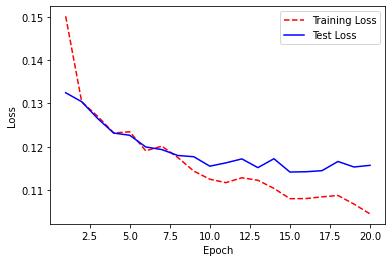

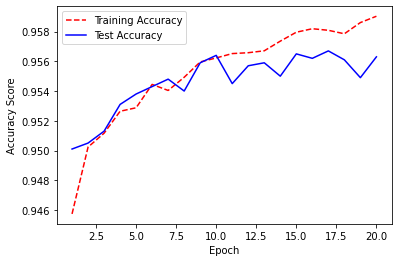

In [26]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Get training and test accuracy histories
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show();

# 4. Dự đoán trong bộ dữ liệu test

**Problem**

Sử dụng mô hình đã xây dựng được để dự đoán trong bộ test dataframe.

**Solution**

Tìm ra một giá trị threshold sẽ mang lại giá trị F1 Score tốt nhất. Sau đó sử dụng giá trị threshold tìm được đó để dự đoán tập dữ liệu.

**Discuss**

Tương tự với việc train model, ở đây ta cũng cần tạo ra các batch chứa dữ liệu để tránh việc tràn bộ nhớ.

In [27]:
pred_val_y = model.predict(val_vects, verbose=False)

best_thres = 0
best_thres_id = 0

for thres in np.arange(0.1, 0.901, 0.01):
    thres = np.round(thres, 2)
    value = metrics.f1_score(val_y, (pred_val_y>thres).astype(int))
    if value > best_thres:
        best_thres = value
        best_thres_id = thres
        
print("The best F1 score is {0} at threshold {1}".format(best_thres, best_thres_id))

The best F1 score is 0.6280729579698652 at threshold 0.29


In [28]:
def batch_gen_for_submit(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i * batch_size: (i + 1) * batch_size, 1]
        text_arr = [text_to_array(text) for text in texts]
        yield np.array(text_arr, dtype=float)

In [29]:
all_preds = []
for x in tqdm(batch_gen_for_submit(test_dataframe)):
    cc = model.predict(x, verbose=False)
    cc = (cc > best_thres_id).astype(int)
    for i in cc:
        all_preds.append(i[0])

1468it [02:19, 10.54it/s]


In [30]:
submit_df = pd.DataFrame({"qid": test_dataframe["qid"], "prediction": all_preds})
submit_df.head(5)

,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


In [31]:
submit_df.to_csv("submission.csv", index=False)